In [5]:
# ######################################################################################################################
#  Initialize: Libraries, functions, parameters
# ######################################################################################################################

# General libraries, parameters and functions
import os
#os.chdir("./code")
import sys
sys.path.append(os.getcwd() + "\\code") 
from HMS_initialize import *
dataloc = "./data/"
plotloc = "./output_HMS/"
 
# hmsPM specific
from hmsPM.calculation import (
    UnivariateFeatureImportanceCalculator,
)
from hmsPM.datatypes import TargetType
from hmsPM.preprocessing import (
    CategoryCollapser,
    Imputer,
    QuantileBinner,
    ScaleConverter,
    TargetEncoder,
    Winsorizer,
)
from hmsPM.plotting import (
    CorrelationPlotter,
    MultiFeatureDistributionPlotter,
)
from hmsPM.utils import detect_target_type

# Silent plotting (Overwrite to get default: plt.ion();  matplotlib.use('TkAgg'))
#plt.ion(); matplotlib.use('TkAgg')
#plt.ioff(); matplotlib.use('Agg')

# Main parameter
TARGET_TYPE = "CLASS"

# Specific parameters (CLASS is default)
ylim = (0, 1)
min_width = 0
cutoff_corr = 0.1
cutoff_varimp = 0.52
if TARGET_TYPE == "MULTICLASS":
    ylim = None
    min_width = 0.2
    cutoff_corr = 0.1
    cutoff_varimp = 0.52
if TARGET_TYPE == "REGR":
    ylim = (0, 300e3)
    cutoff_corr = 0.8
    cutoff_varimp = 0.52


In [6]:
%matplotlib inline
os.getcwd()

'C:\\MY\\Python_PredMod'

In [7]:

# ######################################################################################################################
# ETL
# ######################################################################################################################

# --- Read data ------------------------------------------------------------------------------------------------------

# noinspection PyUnresolvedReferences
if TARGET_TYPE == "CLASS":
    df_orig = pd.read_csv(dataloc + "titanic.csv")
else:
    df_orig = pd.read_csv(dataloc + "AmesHousing.txt", delimiter = "\t")
    df_orig.columns = df_orig.columns.str.replace(" ", "_")
    # alternatively: df_orig.rename(columns = lambda x: x.replace(" ", "_"), inplace=True)
df_orig.describe()
df_orig.describe(include = ["object"])

"""
# Check some stuff
df_values = create_values_df(df_orig, 10)
print(df_values)
if TARGET_TYPE == "CLASS":
    df_orig["survived"].value_counts() / df_orig.shape[0]
if TARGET_TYPE =="REGR":
    fig, ax = plt.subplots(1, 2)
    df_orig["SalePrice"].plot.hist(bins=20, ax = ax[0])
    np.log(df_orig["SalePrice"]).plot.hist(bins=20, ax = ax[1]);
"""

# "Save" original data
df = df_orig.copy()


# --- Read metadata (Project specific) -----------------------------------------------------------------------------

if TARGET_TYPE == "CLASS":
    df_meta = pd.read_excel(dataloc + "datamodel_titanic.xlsx", header = 1)
else:
    df_meta = pd.read_excel(dataloc + "datamodel_AmesHousing.xlsx", header = 1)

# Check
print(setdiff(df.columns.values, df_meta["variable"].values))
print(setdiff(df_meta.loc[df_meta["category"] == "orig", "variable"].values, df.columns.values))

# Filter on "ready"
df_meta_sub = df_meta.loc[df_meta["status"].isin(["ready", "derive"])].reset_index()


# --- Feature engineering -----------------------------------------------------------------------------------------

if TARGET_TYPE == "CLASS":
    df["deck"] = df["cabin"].str[:1]
    df["familysize"] = df["sibsp"] + df["parch"] + 1
    df["fare_pp"] = df["fare"] / df.groupby("ticket")["fare"].transform("count")
    df[["deck", "familysize", "fare_pp"]].describe(include = "all")
if TARGET_TYPE in ["REGR", "MULTICLASS"]:
    pass  # number of rooms, sqm_per_room, ...

# Check
print(setdiff(df_meta["variable"].values, df.columns.values))


# --- Define target and train/test-fold ----------------------------------------------------------------------------

# Target
if TARGET_TYPE == "CLASS":
    df["target"] = df["survived"]
if TARGET_TYPE == "REGR":
    df["target"] = df["SalePrice"]
if TARGET_TYPE == "MULTICLASS":
    df["target"] = QuantileBinner(n_bins = 3, output_format = "quantiles").fit_transform(df["SalePrice"])
df["target"].describe()

# Train/Test fold: usually split by time
np.random.seed(123)
# noinspection PyTypeChecker
df["fold"] = np.random.permutation(
    pd.qcut(np.arange(len(df)), q = [0, 0.1, 0.8, 1], labels = ["util", "train", "test"]))
print(df.fold.value_counts())
df["fold_num"] = df["fold"].replace({"train": 0, "util": 0, "test": 1})  # Used for pedicting test data

# Define the id
df["id"] = np.arange(len(df)) + 1



[]
[]
[]
train    916
test     262
util     131
Name: fold, dtype: int64


In [8]:

# ######################################################################################################################
# Numeric variables: Explore and adapt
# ######################################################################################################################

# --- Define numeric covariates -------------------------------------------------------------------------------------

nume = df_meta_sub.loc[df_meta_sub["type"] == "metr", "variable"].values
df = ScaleConverter(column_names = nume, scale = "numerical").fit_transform(df)
if TARGET_TYPE in ["REGR", "MULTICLASS"]:
    # Zeros are missings in AmesHousing
    df[nume] = df[nume].replace(0, np.nan)
df[nume].describe()

# --- Create nominal variables for all numeric variables (for linear models) before imputing -------------------------
df[nume + "_BINNED"] = QuantileBinner(n_bins = 10, output_format = "quantiles").fit_transform(df[nume])

# Convert missings to own level ("(Missing)")
df[nume + "_BINNED"] = df[nume + "_BINNED"].fillna("(Missing)")
print(create_values_df(df[nume + "_BINNED"], 11))

# Get binned variables with just 1 bin (removed later)
onebin = (nume + "_BINNED")[df[nume + "_BINNED"].nunique() == 1]
onebin



   age_BINNED  age_BINNED_# fare_BINNED  fare_BINNED_# fare_pp_BINNED  fare_pp_BINNED_#
0   (Missing)           263          q3            146             q6               161
1          q7           121          q2            144             q3               146
2          q2           118          q8            134             q2               143
3          q4           110          q1            131             q7               136
4          q3           108         q10            131             q1               134
5          q1           107          q6            130            q10               131
6          q9           100          q7            128             q4               131
7          q6            98          q9            128             q9               128
8          q8            96          q5            128             q5               109
9         q10            95          q4            108             q8                89
10         q5            93   (M

array([], dtype=object)

misspct:
 age        0.201
fare_pp    0.001
fare       0.001
dtype: float64
2.2195041179656982


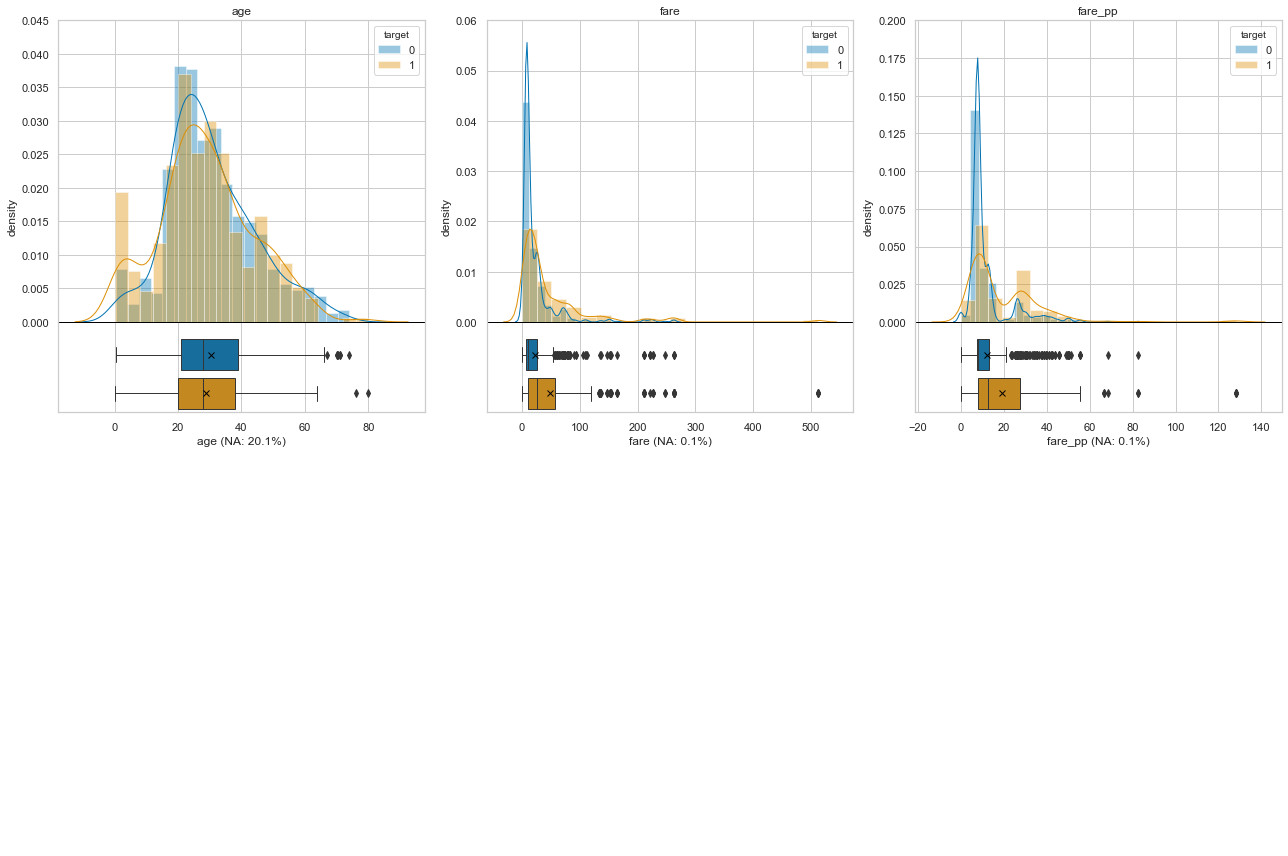

In [9]:

# --- Missings + Outliers + Skewness ---------------------------------------------------------------------------------

# Remove covariates with too many missings from nume
misspct = df[nume].isnull().mean().round(3)  # missing percentage
print("misspct:\n", misspct.sort_values(ascending = False))  # view in descending order
remove = misspct[misspct > 0.95].index.values  # vars to remove
nume = setdiff(nume, remove)  # adapt metadata

# Check for outliers and skewness
df[nume].describe()
import time
start = time.time()
distr_nume_plots = (MultiFeatureDistributionPlotter(n_rows = 2, n_cols = 3, w = 18, h = 12)
                    .plot(features = df[nume],
                          target = df["target"],
                          file_path = plotloc + TARGET_TYPE + "_distr_nume.pdf"))
print(time.time()-start)


In [ ]:

# Winsorize (hint: plot again before deciding for log-trafo)
df = Winsorizer(column_names = nume, quantiles = (0.02, 0.98)).fit_transform(df)

# Log-Transform
if TARGET_TYPE == "CLASS":
    tolog = np.array(["fare"], dtype = "object")
else:
    tolog = np.array(["Lot_Area"], dtype = "object")
df[tolog + "_LOG_"] = df[tolog].apply(lambda x: np.log(x - min(0, np.min(x)) + 1))
nume = np.where(np.isin(nume, tolog), nume + "_LOG_", nume)  # adapt metadata (keep order)
df.rename(columns = dict(zip(tolog + "_BINNED", tolog + "_LOG_" + "_BINNED")), inplace = True)  # adapt binned version


# --- Final variable information ------------------------------------------------------------------------------------

# Univariate variable importance
varimps_nume = (UnivariateFeatureImportanceCalculator(nbins = 10, ndigits = 2)
                .calculate(features = df[np.append(nume, nume + "_BINNED")], target = df["target"]))
print(varimps_nume)

# Plot
distr_nume_plots = (MultiFeatureDistributionPlotter(target_limits = ylim, show_regplot = True,
                                                    n_rows = 2, n_cols = 4, w = 18, h = 12)
                    .plot(features = df[np.column_stack((nume, nume + "_BINNED")).ravel()],
                          target = df["target"],
                          varimps = varimps_nume,
                          file_path = plotloc + TARGET_TYPE + "_distr_nume_final.pdf"))

# --- Removing variables -------------------------------------------------------------------------------------------

# Remove leakage features
remove = ["xxx", "xxx"]
nume = setdiff(nume, remove)

# Remove highly/perfectly (>=98%) correlated (the ones with less NA!)
df[nume].describe()
corr_plot = (CorrelationPlotter(cutoff = cutoff_corr, w = 8, h = 6)
             .plot(features = df[nume], file_path = plotloc + TARGET_TYPE + "_corr_nume.pdf"))
remove = ["xxx", "xxx"]
nume = setdiff(nume, remove)


# --- Time/fold depedency --------------------------------------------------------------------------------------------

# Hint: In case of having a detailed date variable this can be used as regression target here as well!

# Univariate variable importance (again ONLY for non-missing observations!)
varimps_nume_fold = (UnivariateFeatureImportanceCalculator(nbins = 10, ndigits = 2)
                     .calculate(features = df[nume], target = df["fold_num"]))

# Plot: only variables with with highest importance
nume_toprint = varimps_nume_fold[varimps_nume_fold > cutoff_varimp].index.values
distr_nume_folddep_plots = (MultiFeatureDistributionPlotter(n_rows = 2, n_cols = 3, w = 18, h = 12)
                            .plot(features = df[nume_toprint],
                                  target = df["fold_num"],
                                  varimps = varimps_nume_fold,
                                  file_path = plotloc + TARGET_TYPE + "_distr_nume_folddep.pdf"))


# --- Missing indicator and imputation (must be done at the end of all processing)------------------------------------

miss = nume[df[nume].isnull().any().values]  # alternative: [x for x in nume if df[x].isnull().any()]
df["MISS_" + miss] = pd.DataFrame(np.where(df[miss].isnull(), "miss", "no_miss"))
df["MISS_" + miss].describe()

# Impute missings with randomly sampled value (or median, see below)
np.random.seed(123)
df = Imputer(strategy = "median", column_names = miss).fit_transform(df)
df[miss].isnull().sum()


home.dest     369
boat           28
familysize      9
deck            9
parch           8
sibsp           7
embarked        4
pclass          3
sex             2
dtype: int64
['home.dest' 'boat']
boat              0.97
sex               0.76
pclass            0.67
familysize        0.64
deck              0.63
home.dest         0.63
parch             0.59
embarked          0.58
sibsp             0.58
MISS_age          0.54
MISS_fare_pp      0.50
MISS_fare_LOG_    0.50
dtype: float64


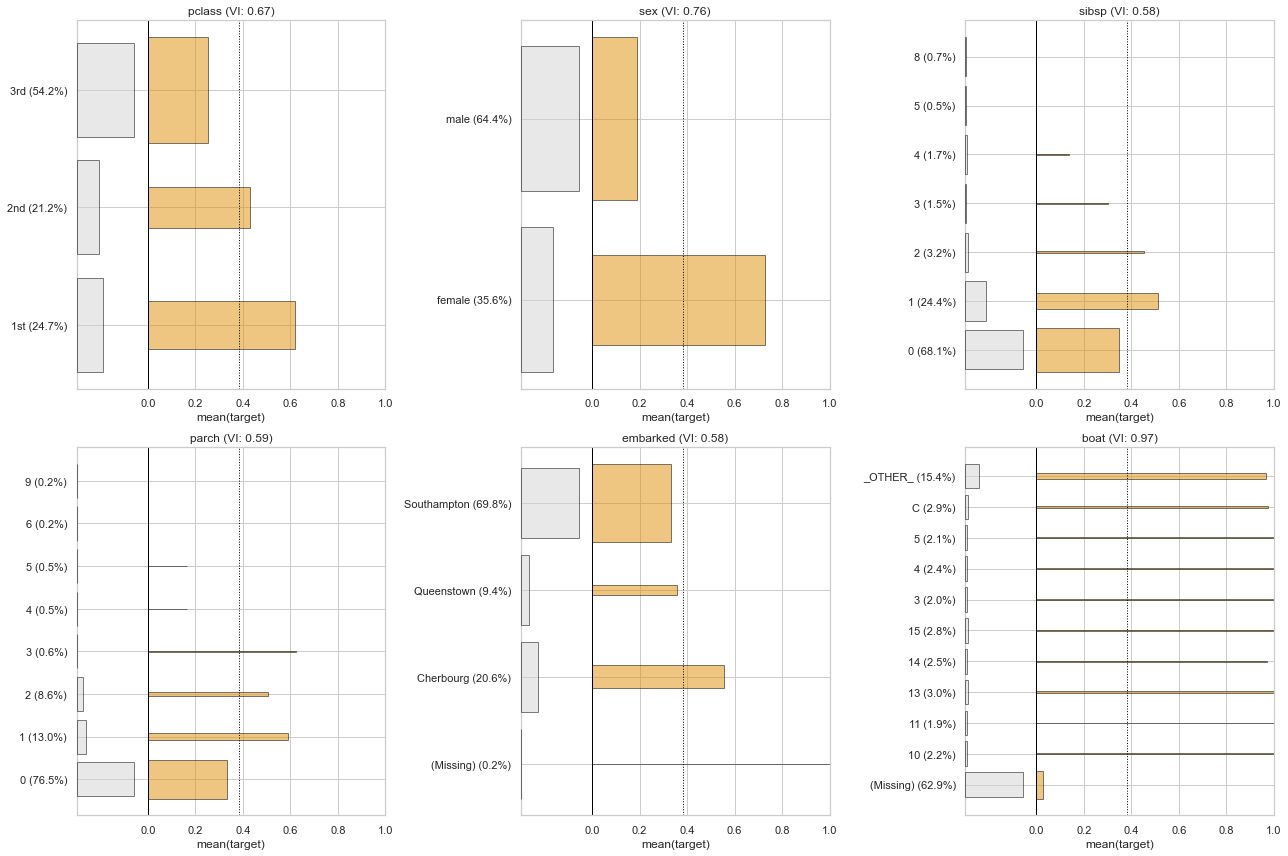

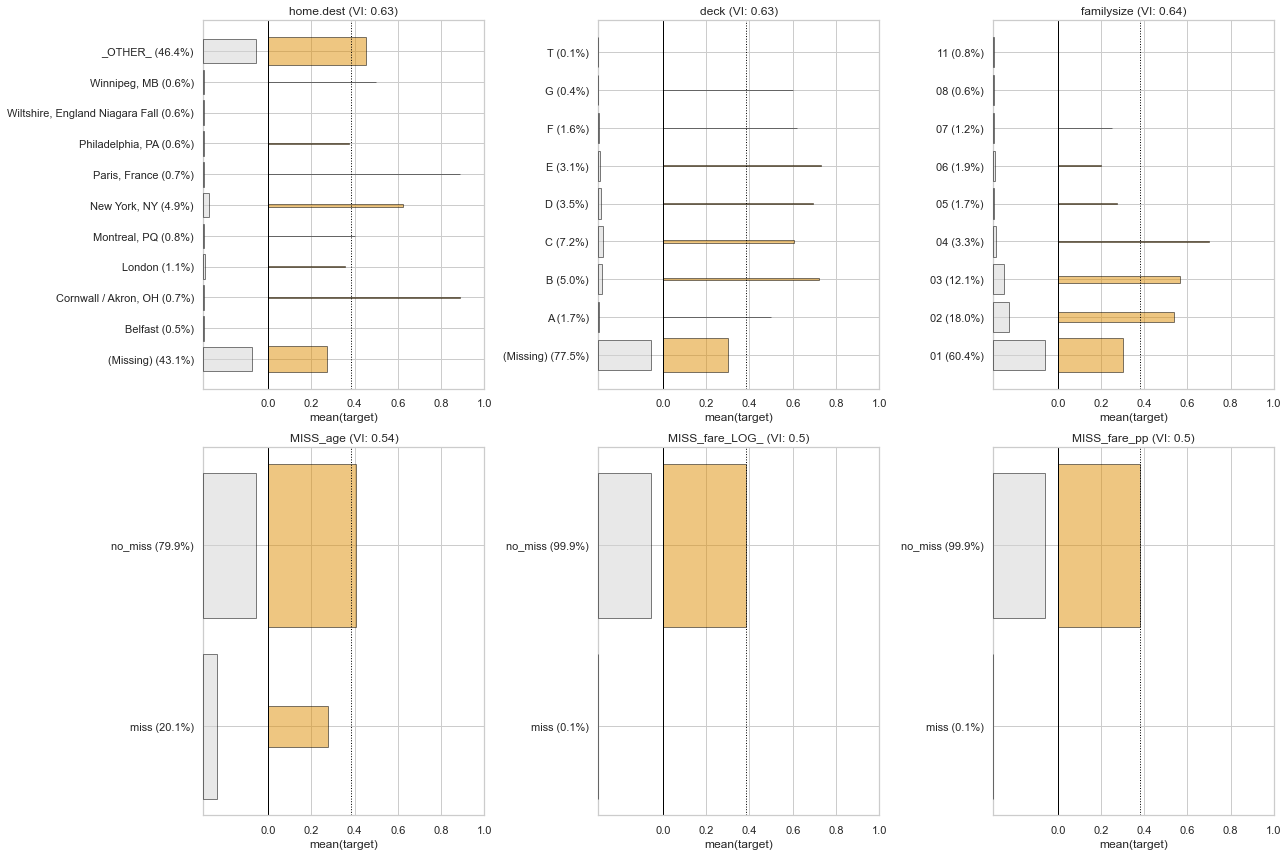

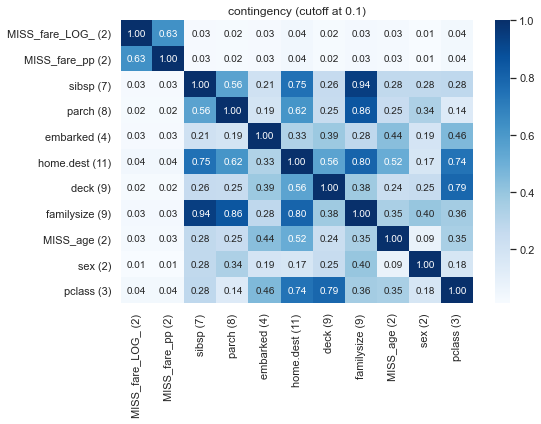

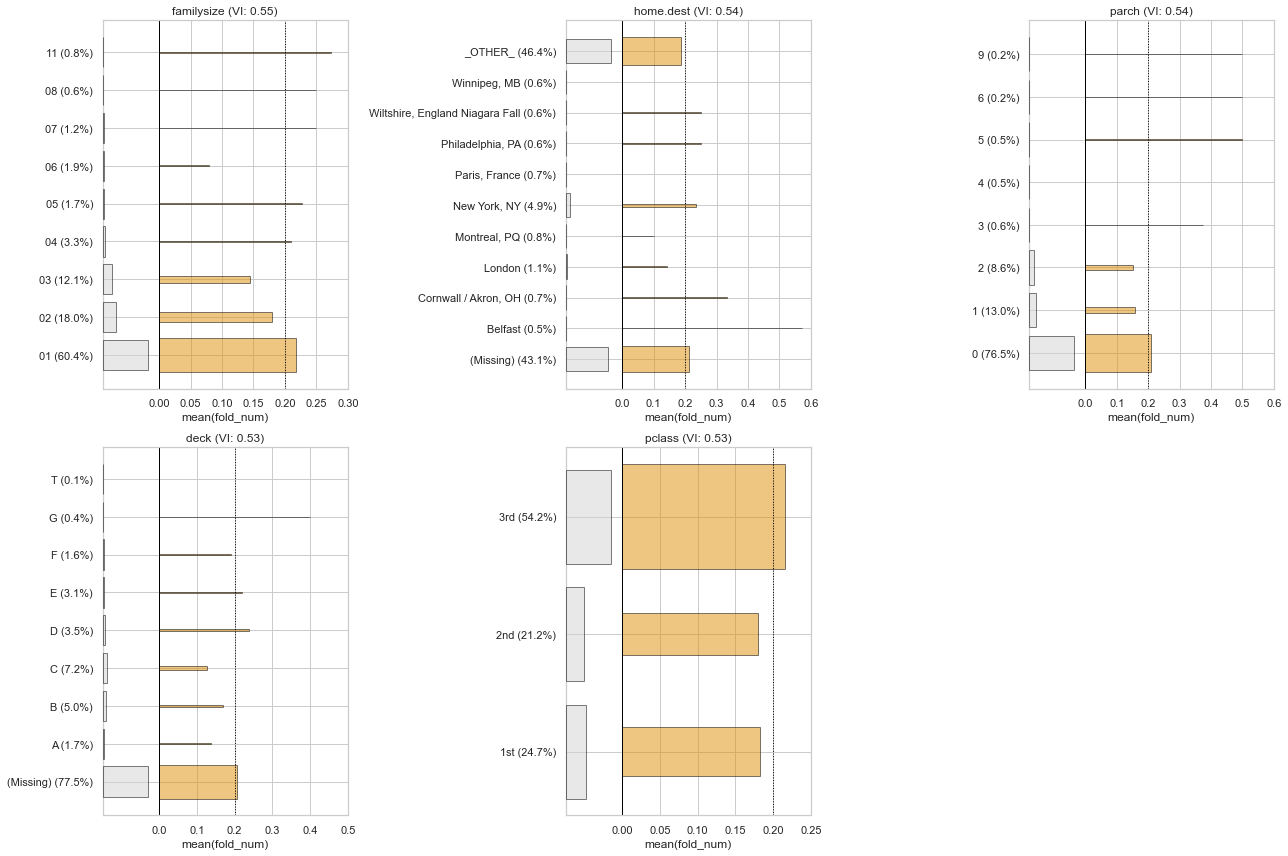

In [26]:

# ######################################################################################################################
# Categorical  variables: Explore and adapt
# ######################################################################################################################

# --- Define categorical covariates -----------------------------------------------------------------------------------

# Categorical variables
cate = df_meta_sub.loc[df_meta_sub.type.isin(["nomi", "ordi"]), "variable"].values
df = ScaleConverter(column_names = cate, scale = "categorical").fit_transform(df)
df[cate].describe()

# Convert ordinal features to make it "alphanumerically sorted"
if TARGET_TYPE == "CLASS":
    df["familysize"] = df["familysize"].str.zfill(2)
else:
    tmp = ["Overall_Qual", "Overall_Cond", "Bsmt_Full_Bath", "Full_Bath", "Half_Bath", "Bedroom_AbvGr",
           "TotRms_AbvGrd", "Fireplaces", "Garage_Cars"]
    df[tmp] = df[tmp].apply(lambda x: x.str.zfill(2))


# --- Handling factor values ----------------------------------------------------------------------------------------

# Convert "standard" features: map missings to own level
df[cate] = df[cate].fillna("(Missing)")
df[cate].describe()

# Get "too many members" columns and copy these for additional encoded features (for tree based models)
topn_toomany = 10
levinfo = df[cate].nunique().sort_values(ascending = False)  # number of levels
print(levinfo)
toomany = levinfo[levinfo > topn_toomany].index.values
print(toomany)
toomany = setdiff(toomany, ["xxx", "xxx"])  # set exception for important variables

# Create encoded features (for tree based models), i.e. numeric representation
df[cate + "_ENCODED"] = (TargetEncoder(subset_index = np.arange(len(df))[df["fold"] == "util"])
                         .fit_transform(df[cate], df["target"]))
df["MISS_" + miss + "_ENCODED"] = df["MISS_" + miss].apply(lambda x: x.map({"no_miss": 0, "miss": 1}))
''' 
# BUG: Some non-exist even they do exist
i = 4
print(df[[cate[i],cate[i] + "_ENCODED"]].drop_duplicates())
print(df[df["fold"] == "util"][cate[i]].value_counts())
'''

# Convert toomany features: lump levels and map missings to own level
df[toomany] = CategoryCollapser(n_top = 10).fit_transform(df[toomany])

# Univariate variable importance
varimps_cate = (UnivariateFeatureImportanceCalculator(ndigits = 2)
                .calculate(features = df[ np.append(cate, ["MISS_" + miss])], target = df["target"]))
print(varimps_cate)

# Check
distr_cate_plots = (MultiFeatureDistributionPlotter(target_limits = ylim, min_bar_width = min_width,
                                                    n_rows = 2, n_cols = 3, w = 18, h = 12)
                    .plot(features = df[np.append(cate, ["MISS_" + miss])],
                          target = df["target"],
                          varimps = varimps_cate,
                          file_path = plotloc + TARGET_TYPE + "_distr_cate.pdf"))


# --- Removing variables ---------------------------------------------------------------------------------------------

# Remove leakage variables
if TARGET_TYPE == "CLASS":
    cate = setdiff(cate, ["boat", "xxx"])
    toomany = setdiff(toomany, ["boat", "xxx"])

# Remove highly/perfectly (>=99%) correlated (the ones with less levels!)
corr_cate_plot = (CorrelationPlotter(cutoff = cutoff_corr, w = 8, h = 6)
                 .plot(features = df[np.append(cate, ["MISS_" + miss])],
                       file_path = plotloc + TARGET_TYPE + "_corr_cate.pdf"))


# --- Time/fold depedency --------------------------------------------------------------------------------------------

# Hint: In case of having a detailed date variable this can be used as regression target here as well!
# Univariate variable importance (again ONLY for non-missing observations!)
varimps_cate_fold = (UnivariateFeatureImportanceCalculator(ndigits = 2)
                     .calculate(features = df[np.append(cate, ["MISS_" + miss])], target = df["fold_num"]))

# Plot: only variables with with highest importance
cate_toprint = varimps_cate_fold[varimps_cate_fold > cutoff_varimp].index.values
distr_cate_folddep_plots = (MultiFeatureDistributionPlotter(n_rows = 2, n_cols = 3, w = 18, h = 12)
                            .plot(features = df[cate_toprint],
                                  target = df["fold_num"],
                                  varimps = varimps_cate_fold,
                                  file_path = plotloc + TARGET_TYPE + "_distr_cate_folddep.pdf"))



In [5]:
import numpy as np